# <span style="color:orange">**Prepare the EAGLEI data and concatenate them in a single CSV**</span>
___
___

### <u>Objective:</u> get hourly records (not every 15 minutes) and delete columns to save memory.
- Open all Eaglei data (containing outages) for a selection of years (available: 2014 to 2023).
- Aggregate the data to one row per hour (instead of 1 row per 15min).
- Delete some columns to save memory (e.g. county or state names).

___
___
# **Librairies & Utils**

In [1]:
from utility_script_dynamic_rythms import *

___
___
# **Before creating CSV, let's plot a map with outages in 2023**
> Percentages of days with at least 1 hour of outages,  at county-level and state-level.

### **Prepare dataset**

In [2]:
%%time

df = pd.read_csv(filedir + "eaglei_data/eaglei_outages_2023.csv") # , nrows=10000
    
# Rename for clarity
df = df.rename(columns = {'customers_out' : 'outages', 'fips_code' : 'fips'})

# Get date features
df = extract_date_features(df, time_col='run_start_time')

# Filter rows with very few outages
df = df[df['outages'] >= 5].reset_index(drop=True)

# Count hours of outages by day (1/4 hour = 15 minutes)
df['hours_of_outages_this_day'] = (1/4) * df.groupby(['date', 'fips'])['outages'].transform('count')

# Filter rows with at least 1 hour of outages per day
df = df[df['hours_of_outages_this_day'] >= 1].reset_index(drop=True)

# Count the number of days per fips with more than 1 hour of outages
df = df.groupby(['state', 'fips'])['date'].nunique().reset_index()

# Rename for clarity
df.columns = ['state', 'fips', 'days_with_serious_outages']

# Show
print(df.shape)
df.head(3)

(2985, 3)
CPU times: user 1min 22s, sys: 11.2 s, total: 1min 33s
Wall time: 1min 52s


,state,fips,days_with_serious_outages
0,Alabama,1001,265
1,Alabama,1003,358
2,Alabama,1005,151


### **Outages Frequency at County-level**
> Percentages of days with at least 1 hour of outages.

Observations :
- Some fips are missing.
- Coasts are more severly touched by outages (higher population density + more severe weather events).

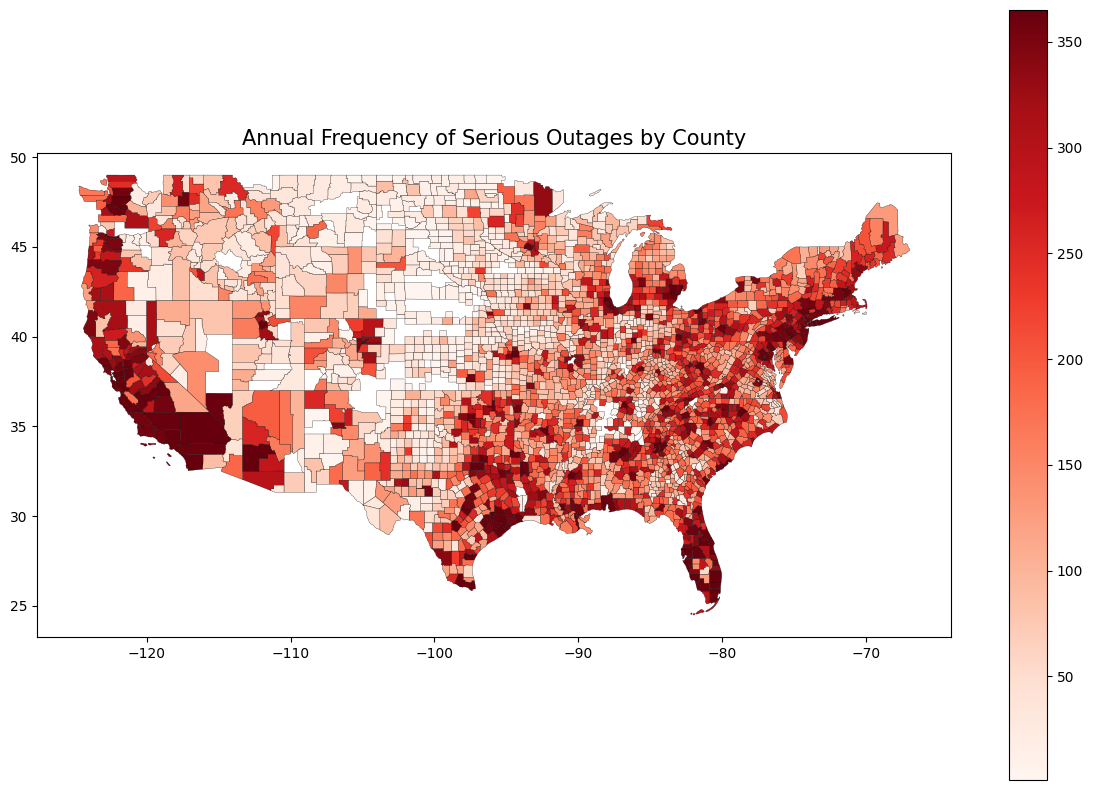

In [3]:
# Show map (county level)
plot_fips_on_map(df, color_col='days_with_serious_outages')

### **Outages Frequency at State-level**
> Percentages of days with at least 1 hour of outages.

Observation :
- Coasts are more severly touched by outages (higher population density + more severe weather events).

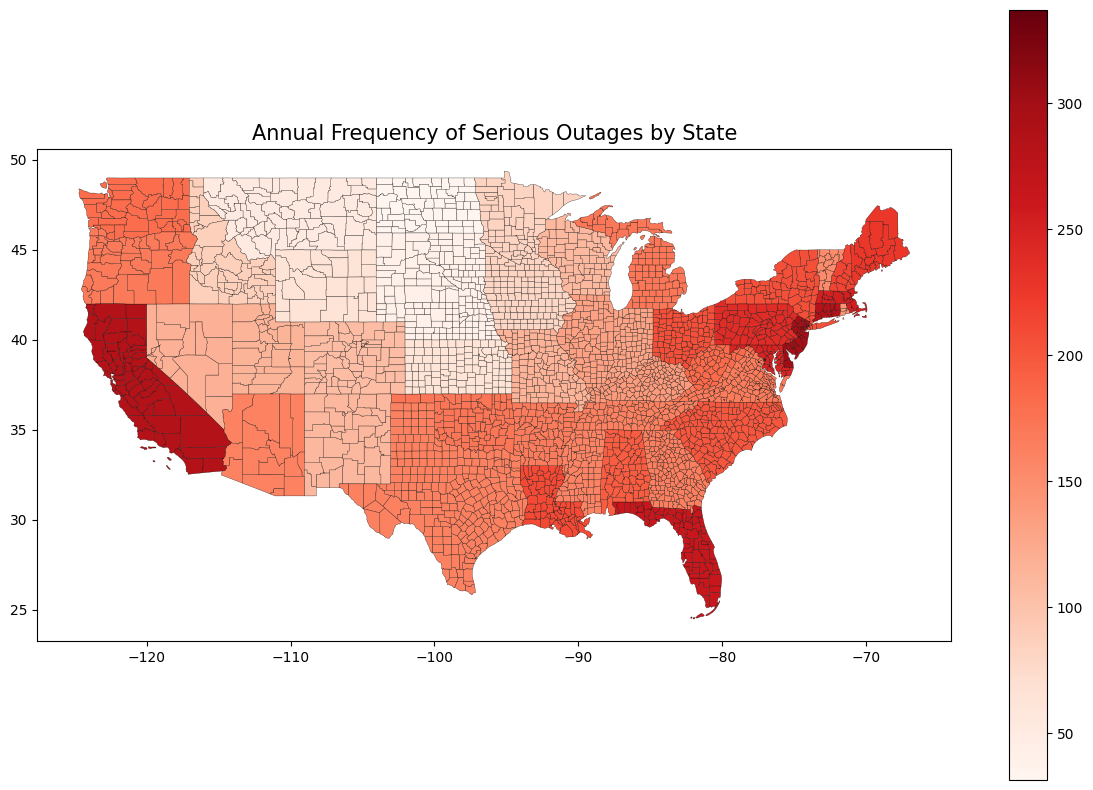

In [4]:
# Filter rows with very few outages
df_state = df.groupby(['state'])['days_with_serious_outages'].mean().reset_index()

# Show map (state  level)
plot_state_on_map(df_state, color_col='days_with_serious_outages')

___
___
# **Process Data**
- Open all Eaglei data (containing outages) for a selection of years (available: 2014 to 2023).
- Aggregate the data to one row per hour (instead of 1 row per 15min).
- Delete some columns to save memory (e.g. county or state names).

In [5]:
%%time

# Initialize df containing all data
df_all = None

# Columns to export
cols_to_export = ['fips',
                  #'county',
                  #'state',
                  'date',
                  'hour',
                  'outages',
                 ]

# Iterate over years (data are available since 2014 but you can just take 2023 for inference)
for year in range(2023, 2024):

    # Open CSV
    df = pd.read_csv(filedir + f"eaglei_data/eaglei_outages_{year}.csv") # , nrows=10000
    
    # Rename for clarity
    df = df.rename(columns = {'customers_out' : 'outages', 'fips_code' : 'fips'})

    # Get date features
    df = extract_date_features(df, time_col='run_start_time')
    
    # Map state
    df['state'] = df['state'].map(state_abbreviations)
    
    # Aggregate to hourly rows (one row every 15min consumes tool much memory)
    df = aggregate_df_hourly(df)

    # Delete rows where hourly outages are null
    df = df[df['outages'] > 0].reset_index(drop=True)

    # Add df to df_all
    df_all = pd.concat([df_all, df[cols_to_export]], ignore_index=True)

    # Print information
    print(f"Year {year} : {len(df)} rows. --> Total : {len(df_all)} rows.\n" )

# Show
print(df_all.shape)
df_all.head()

Year 2023 : 7300990 rows. --> Total : 7300990 rows.

(7300990, 4)
CPU times: user 1min 27s, sys: 11.5 s, total: 1min 39s
Wall time: 1min 38s


,fips,date,hour,outages
0,1001,2023-01-01,1,7
1,1001,2023-01-01,2,4
2,1001,2023-01-01,3,4
3,1001,2023-01-01,4,4
4,1001,2023-01-01,5,4


___
___
# **Export df_all as CSV**

In [6]:
%%time

# Export as CSV
df_all.to_csv(output_dirpath + "df.csv", index=False)

CPU times: user 9.26 s, sys: 237 ms, total: 9.49 s
Wall time: 9.5 s
